# Spoken Digit Recognition
Let's have a walk through on using Julia for Spoken Digit Recognition. Here, we will use CNN model on the spectrogram values to predict the Digit.<br>
We begin with importing all the important packages

In [1]:
using DSP,WAV
using PyCall
using PyPlot
using MFCC
using FFTW
using Flux
using Printf,BSON
using Flux: onehotbatch, onecold, crossentropy, throttle, Conv,relu
using Base.Iterators: partition
using StatsBase
using MLLabelUtils,MLDataPattern
IpY = pyimport("IPython")
using Images


┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/blackforest/.julia/packages/CUDAdrv/mCr0O/src/CUDAdrv.jl:69


## Loading the Data
Once we have imported the packages, let's load the data

In [3]:
cd("./Downloads")
A = readdir("./Spoken_Digit/recordings")
cd("./Spoken_Digit/recordings")
X = []
X_fs = []
Y = []
for i in 1:length(A)
    s,fs = wavread(A[i])
    push!(X,s)
    push!(X_fs,fs)
    push!(Y,Int(A[i][1]-'0'))
end
cd("./../../")

## Analysing the Data

Let's first listen to the what these audio WAV files contain. For this, we will use here, IPython.display.Audio. In order 

In [4]:
IpY = pyimport("IPython")

PyObject <module 'IPython' from '/home/blackforest/.julia/conda/3/lib/python3.7/site-packages/IPython/__init__.py'>

In [5]:
IpY.display.Audio(A[453])

PyObject <IPython.lib.display.Audio object>

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = show(::IOContext{Base.GenericIOBuffer{Array{UInt8,1}}}, ::MIME{Symbol("text/html")}, ::PyObject) at PyCall.jl:895
└ @ PyCall /home/blackforest/.julia/packages/PyCall/ttONZ/src/PyCall.jl:895


Hmm, that does sound like two. So, similar kind of audio data, we need to classify through our model. Before going into building the model, first pre-analyse the audio files
<br>
First, let's plot our data to see what it looks like.  

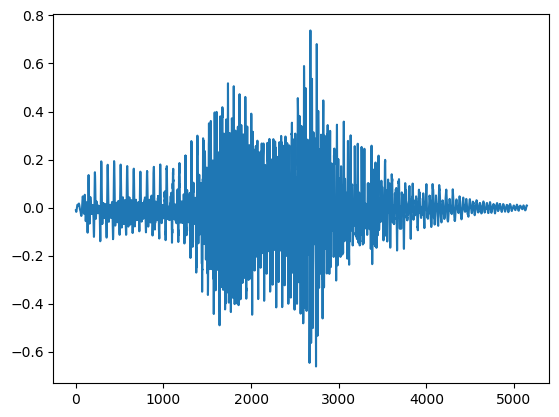

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6a702369d0>

In [6]:
PyPlot.plot(X[1])

How about an FFT plot?

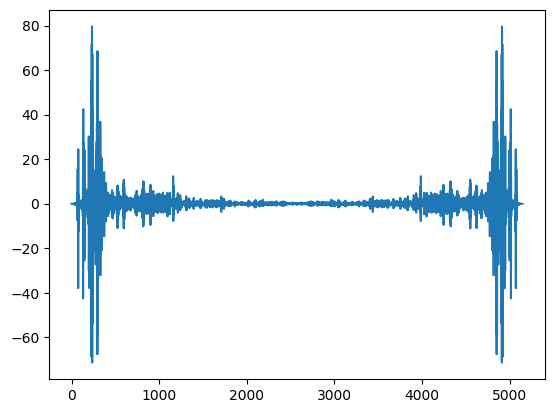

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6a4f78e7d0>

In [7]:
PyPlot.plot(fft(X[1]))

Now, we will plot the spectrogram of the audio file zero

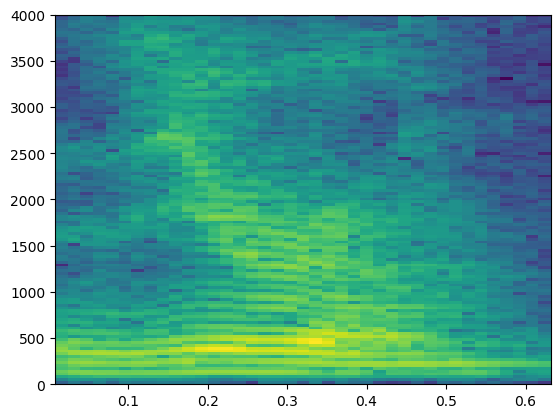

([5.921396503211639e-11 6.144594757755415e-10 … 8.451382701637563e-12 1.756504456288814e-12; 1.8568523198236493e-9 1.0536784714698365e-8 … 2.8469931152361586e-9 5.448721894513743e-10; … ; 1.9158576126187585e-11 1.5013662229371582e-10 … 5.123048834666636e-12 1.0419974773609225e-11; 4.380290940223674e-12 6.62498304638197e-11 … 7.044207901278974e-13 1.4417284840034432e-12], [0.0, 31.25, 62.5, 93.75, 125.0, 156.25, 187.5, 218.75, 250.0, 281.25  …  3718.75, 3750.0, 3781.25, 3812.5, 3843.75, 3875.0, 3906.25, 3937.5, 3968.75, 4000.0], [0.016, 0.032, 0.048, 0.064, 0.08, 0.096, 0.112, 0.128, 0.144, 0.16  …  0.48, 0.496, 0.512, 0.528, 0.544, 0.56, 0.576, 0.592, 0.608, 0.624], PyObject <matplotlib.image.AxesImage object at 0x7f6a4f7b4d10>)

In [8]:
c = PyPlot.specgram(X[1][:,1],Fs = X_fs[1])

We will use here, spectrogram function of the DSP.jl to calculate the spectrogram values of the given audio files

In [12]:
Y1_spec = spectrogram(X[1][:,1])

DSP.Periodograms.Spectrogram{Float64,AbstractFFTs.Frequencies{Float64}}([1.1931071772691992e-5 1.2794204112795591e-5 … 8.094883618521913e-6 3.1319986816039646e-7; 2.8106639028433923e-5 5.084930866656072e-5 … 1.2141545106504503e-5 3.206747897719205e-6; … ; 5.1947719534789895e-6 3.854394968184458e-5 … 3.116387268187047e-7 5.890268409838297e-7; 1.0890568868333794e-5 1.4311608044292973e-6 … 8.204829844873038e-8 9.867262443729622e-8], [0.0, 0.0015432098765432098, 0.0030864197530864196, 0.004629629629629629, 0.006172839506172839, 0.007716049382716049, 0.009259259259259259, 0.010802469135802469, 0.012345679012345678, 0.013888888888888888  …  0.4861111111111111, 0.48765432098765427, 0.4891975308641975, 0.4907407407407407, 0.4922839506172839, 0.49382716049382713, 0.49537037037037035, 0.49691358024691357, 0.4984567901234568, 0.5], 321.5:322.0:4507.5)

In [10]:
fieldnames(typeof(Y1_spec))

(:power, :freq, :time)

What it returns? It basically returns us the an array of power values in a timeframe of audio over different frequencies

In [11]:
Y1_spec.power

325×14 Array{Float64,2}:
 1.19311e-5   1.27942e-5   0.00011184   …  8.09488e-6   3.132e-7   
 2.81066e-5   5.08493e-5   0.000233652     1.21415e-5   3.20675e-6 
 4.0484e-5    0.000131717  0.000272207     1.73776e-5   7.20905e-6 
 6.07955e-5   0.000288517  0.000365978     1.14003e-5   1.46983e-5 
 0.000143712  0.000636645  0.00057366      2.13868e-6   4.70806e-5 
 0.000151799  0.000645508  0.000853296  …  0.00012986   1.36235e-5 
 0.000532065  0.00209559   0.00180169      2.45591e-5   1.48478e-5 
 0.00170353   0.00590174   0.00495622      0.000241027  0.000286993
 0.0141123    0.039983     0.0309246       0.00337389   0.0041309  
 0.260717     0.247433     0.247253        0.0691463    0.0274001  
 0.0209742    0.0233435    0.0205739    …  0.00312731   0.0129292  
 0.0031157    0.00721872   0.0106745       0.000916135  0.0025006  
 0.00265383   0.00263328   0.00643533      0.00131455   0.00261374 
 ⋮                                      ⋱                          
 7.07666e-8   9.66128e-

## Data Preprocessing
As discussed above, we will be using spectrogram values of the audio files as input to our CNN model. Let's generate the spectrograms of all the audio files. Here,we will be using the power values of the spectrogram as out image data at different frequencies

In [13]:
imgs = []
for i in 1:length(X)
    b = spectrogram(X[i][:,1])
    push!(imgs,b.power)
end

In [14]:
labels = Y;

As our data is arranged in order,we first need to shuffle the data.

### Normalising the data
Normalising plays a very crucial role in easy convergence of the data, otherwise there are more chances of the model getting stuck in the local optimum. So we will normalise the data.

In [18]:
for i in 1:length(imgs)
    imgs[i] = Flux.normalise(imgs[i],dims=2)
end

In [19]:
imgs_,labels_ = shuffleobs((imgs,labels));

Now, we will use only 85% of the data as our training data in this example. And the rest of the data, we will use to test our model

In [22]:
train_X,train_Y = imgs_[1:1701],labels_[1:1701];

Our spectrogram values will be of different sizes. So we need to change them to into a common size before making batches. So here, we will be resizing spectrograms to image size of (256,32). It is preferable not to keep the size too small, as otherwise while shrinking the size, some data may get lost. Also very large size is not preferrable as it will consequently increase the traning time. 

In [23]:
img_size = (256,32)
m,n = img_size

(256, 32)

Using the following function, we will divide the array into minibatches along with resizing the images to the required shape.

In [24]:
function make_minibatch(X,Y,idxs)
    X_batch = Array{Float32}(undef,(img_size)..., 1, length(idxs))
    for i in 1:length(idxs)
        img = Float32.(imresize((X[idxs[i]]),(img_size)...))
        X_batch[:, :, :, i] = img
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

Note that here we are using a batch size of 32, that seems reasonable in this case as the training data size is 1700 which isn't that big. So, batch_size of 32 seems to be an appropriate choice

In [25]:
mb_indices = [] 
batch_size = 32

for i in range(1,length(train_Y)-1,step = batch_size)
    idxs = []
    for j in i:i+batch_size-1
        push!(idxs,j)
    end
    push!(mb_indices,idxs)
end
train_set = [make_minibatch(train_X,train_Y,mb_indices[i]) for i in 1:(size(mb_indices)[1]-1)];

In [26]:
size(train_set[1][1])

(256, 32, 1, 32)

We will be supplying our whole test data as a single batch. So let's create our test set

In [27]:
batch_size=300
ind = []
for i in 1701:2000
    push!(ind,i)
end
test_set = [make_minibatch(imgs_,labels_,ind)];

## Model
Once, we are done pre-processing tha data and our data is ready to get the model trained, its time to create our model.

In [36]:
@info("Constructing model...")
model = Chain(
    # First convolution, operating upon a m*n image
    Conv((3, 3), 1=>64, pad=(1,1), relu),
    MaxPool((2,2)),
    BatchNorm(64,relu),

    # Second convolution, operating upon a m/2*n/2 image
    Conv((3, 3), 64=>32, pad=(1,1), relu),
    MaxPool((2,2)),
    BatchNorm(32,relu),
    Dropout(0.10),
    
    # Reshape 3d tensor into a 2d one, at this point it should be (m/4,n/4,32, N)
    # which is where we get the 2048 in the `Dense` layer below:
    x -> reshape(x, :, size(x, 4)),
    Dense(Int(floor(m/4)*floor(n/4)*32), 128,relu),
    
    Dense(128,10),

    # Finally, softmax to get nice probabilities
    softmax,
)

┌ Info: Constructing model...
└ @ Main In[36]:1


Chain(Conv((3, 3), 1=>64, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(64, λ = relu), Conv((3, 3), 64=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(32, λ = relu), Dropout(0.1), #7, Dense(16384, 128, relu), Dense(128, 10), softmax)

In this model, we will use crossentropy loss. While calculating loss, we will simply add some random noise to our data, so as to prevent the overfitting

In [37]:
function loss(x, y)
    # We augment `x` a little bit here, adding in random noise
    x_aug = x .+ 0.1f0*(randn(eltype(x), size(x)))

    y_hat = model(x_aug)
    return crossentropy(y_hat, y)
end
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

What is accuracy before training the model?????<br>
Let's check.......

In [38]:
accuracy(test_set[1]...)

0.08333333333333333

## Training
Let's begin training our model. We will use ere ADAM optimiser with a learning rate of 0.001. We will train our model for 15 epochs

In [39]:
opt = ADAM(0.001)
epochs = 15

@info("Beginning training loop...")
best_acc = 0.0
last_improvement = 0
for epoch_idx in 1:epochs
    global best_acc, last_improvement
    # Train for a single epoch
    Flux.train!(loss, params(model), train_set, opt)
    x,y = train_set[1] 
    print("Epoch[$epoch_idx]: Train_Loss: ",loss(x,y),"\n")
    
    # Calculate accuracy:
    acc = accuracy(test_set[1]...)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= 0.95
        @info(" -> Early-exiting: We reached our target accuracy of 95.0%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to MNIST_Speech.bson") #Here, model is saved as MNIST_Speech.bson        
        BSON.@save joinpath(dirname(@__FILE__), "./MNIST_Speech.bson") model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-4
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[39]:4


Epoch[1]: Train_Loss: 0.39074132


┌ Info: [1]: Test accuracy: 0.6767
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[2]: Train_Loss: 0.013040102


┌ Info: [2]: Test accuracy: 0.8567
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[3]: Train_Loss: 0.033996206


┌ Info: [3]: Test accuracy: 0.8600
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[4]: Train_Loss: 0.0029821368


┌ Info: [4]: Test accuracy: 0.9200
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[5]: Train_Loss: 0.0010024133


┌ Info: [5]: Test accuracy: 0.9167
└ @ Main In[39]:16


Epoch[6]: Train_Loss: 0.00067962485


┌ Info: [6]: Test accuracy: 0.9200
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[7]: Train_Loss: 0.0005679158


┌ Info: [7]: Test accuracy: 0.9233
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[8]: Train_Loss: 0.00038421655


┌ Info: [8]: Test accuracy: 0.9233
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[9]: Train_Loss: 0.00037415794


┌ Info: [9]: Test accuracy: 0.9233
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[10]: Train_Loss: 0.00028696572


┌ Info: [10]: Test accuracy: 0.9233
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[11]: Train_Loss: 0.00027806658


┌ Info: [11]: Test accuracy: 0.9267
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[12]: Train_Loss: 0.00019297587


┌ Info: [12]: Test accuracy: 0.9267
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[13]: Train_Loss: 0.00020029144


┌ Info: [13]: Test accuracy: 0.9267
└ @ Main In[39]:16
┌ Info:  -> New best accuracy! Saving model out to MNIST_Speech.bson
└ @ Main In[39]:26


Epoch[14]: Train_Loss: 0.00018595633


┌ Info: [14]: Test accuracy: 0.9233
└ @ Main In[39]:16


Epoch[15]: Train_Loss: 0.00021959198


┌ Info: [15]: Test accuracy: 0.9233
└ @ Main In[39]:16


Now our model is trained and ready to be tested